Train samples: 2195, Val samples: 549


/home/ppaiva/.local/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/ppaiva/.local/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Visualizing features BEFORE training...


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x1465150851c0>
Traceback (most recent call last):
  File "/sw/pkgs/arc/python3.11-anaconda/2024.02-1/lib/python3.11/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/sw/pkgs/arc/python3.11-anaconda/2024.02-1/lib/python3.11/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/sw/pkgs/arc/python3.11-anaconda/2024.02-1/lib/python3.11/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
                   ^^^^^^^^^^^^^^^^^^
  File "/sw/pkgs/arc/python3.11-anaconda/2024.02-1/lib/python3.11/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split

Label counts: Counter({2: 198, 1: 177, 0: 174})


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x1464082af060>
Traceback (most recent call last):
  File "/sw/pkgs/arc/python3.11-anaconda/2024.02-1/lib/python3.11/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/sw/pkgs/arc/python3.11-anaconda/2024.02-1/lib/python3.11/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/sw/pkgs/arc/python3.11-anaconda/2024.02-1/lib/python3.11/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
                   ^^^^^^^^^^^^^^^^^^
  File "/sw/pkgs/arc/python3.11-anaconda/2024.02-1/lib/python3.11/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split

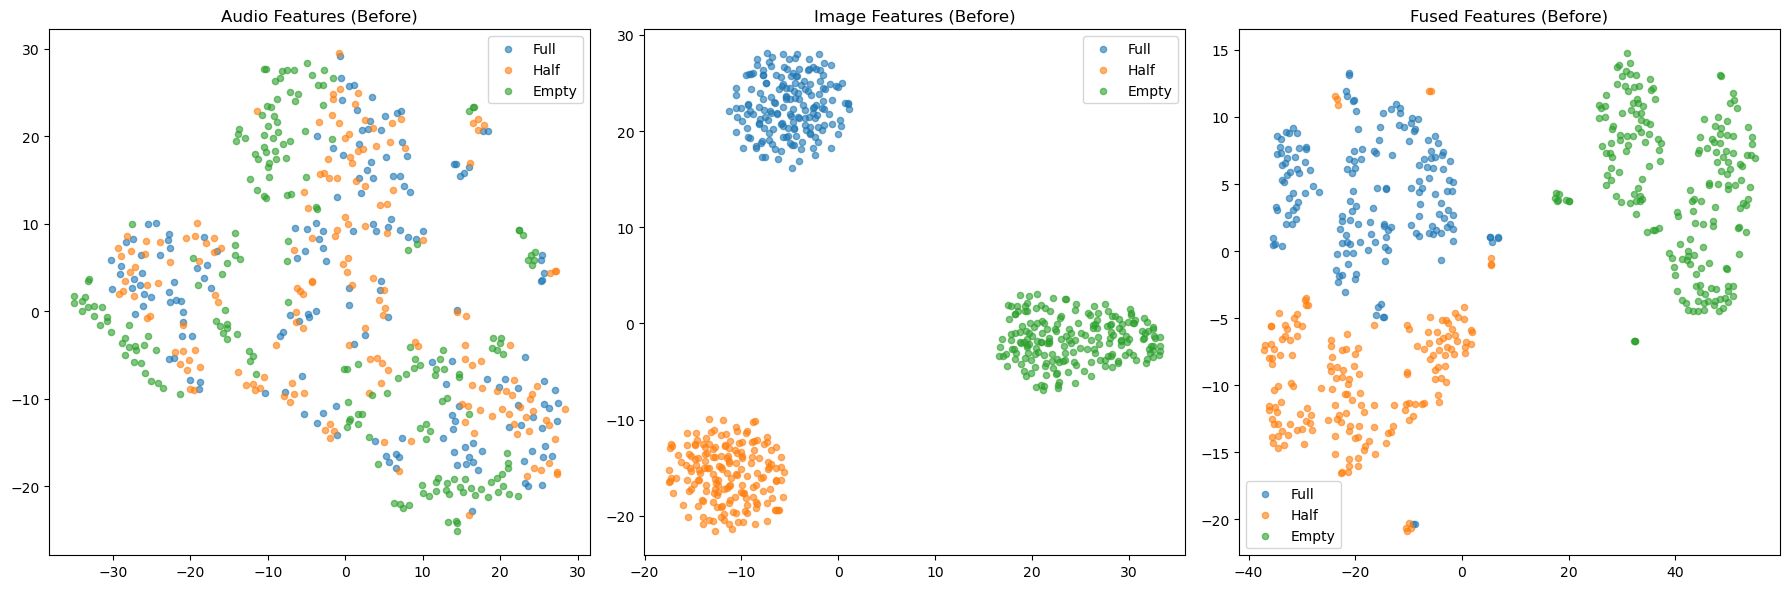

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [1/15] Train Loss: 0.0263, Train Acc: 0.9909, Val Loss: 0.0001, Val Acc: 1.0000


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x146408a39f80>
Traceback (most recent call last):
  File "/sw/pkgs/arc/python3.11-anaconda/2024.02-1/lib/python3.11/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/sw/pkgs/arc/python3.11-anaconda/2024.02-1/lib/python3.11/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/sw/pkgs/arc/python3.11-anaconda/2024.02-1/lib/python3.11/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
                   ^^^^^^^^^^^^^^^^^^
  File "/sw/pkgs/arc/python3.11-anaconda/2024.02-1/lib/python3.11/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split

Label counts: Counter({2: 198, 1: 177, 0: 174})


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x146408a39f80>
Traceback (most recent call last):
  File "/sw/pkgs/arc/python3.11-anaconda/2024.02-1/lib/python3.11/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/sw/pkgs/arc/python3.11-anaconda/2024.02-1/lib/python3.11/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/sw/pkgs/arc/python3.11-anaconda/2024.02-1/lib/python3.11/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
                   ^^^^^^^^^^^^^^^^^^
  File "/sw/pkgs/arc/python3.11-anaconda/2024.02-1/lib/python3.11/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split

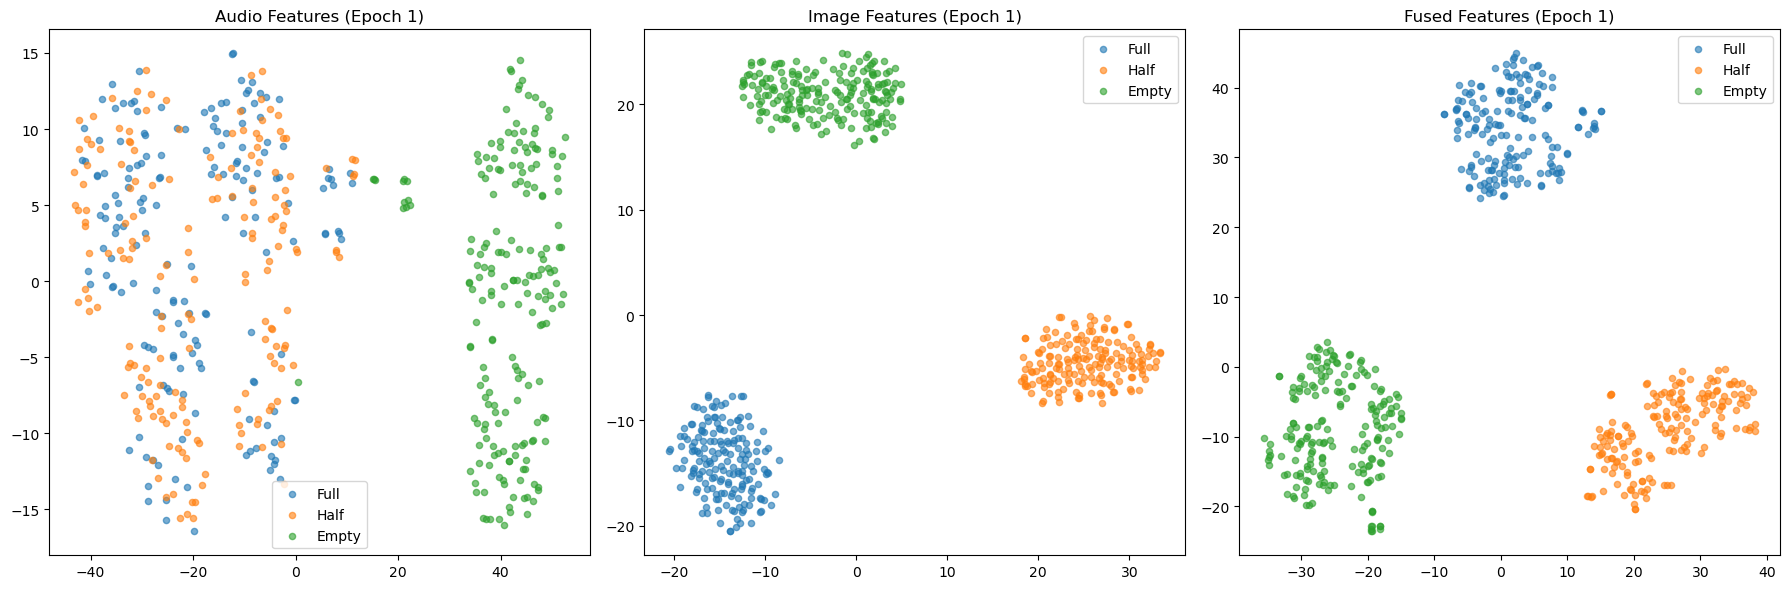

  7%|▋         | 1/15 [04:45<1:06:39, 285.65s/it]

Epoch [2/15] Train Loss: 0.0005, Train Acc: 1.0000, Val Loss: 0.0000, Val Acc: 1.0000


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x146408a3b1a0>
Traceback (most recent call last):
  File "/sw/pkgs/arc/python3.11-anaconda/2024.02-1/lib/python3.11/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/sw/pkgs/arc/python3.11-anaconda/2024.02-1/lib/python3.11/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/sw/pkgs/arc/python3.11-anaconda/2024.02-1/lib/python3.11/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
                   ^^^^^^^^^^^^^^^^^^
  File "/sw/pkgs/arc/python3.11-anaconda/2024.02-1/lib/python3.11/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split

Label counts: Counter({2: 198, 1: 177, 0: 174})


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x146408a3b1a0>
Traceback (most recent call last):
  File "/sw/pkgs/arc/python3.11-anaconda/2024.02-1/lib/python3.11/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/sw/pkgs/arc/python3.11-anaconda/2024.02-1/lib/python3.11/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/sw/pkgs/arc/python3.11-anaconda/2024.02-1/lib/python3.11/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
                   ^^^^^^^^^^^^^^^^^^
  File "/sw/pkgs/arc/python3.11-anaconda/2024.02-1/lib/python3.11/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split

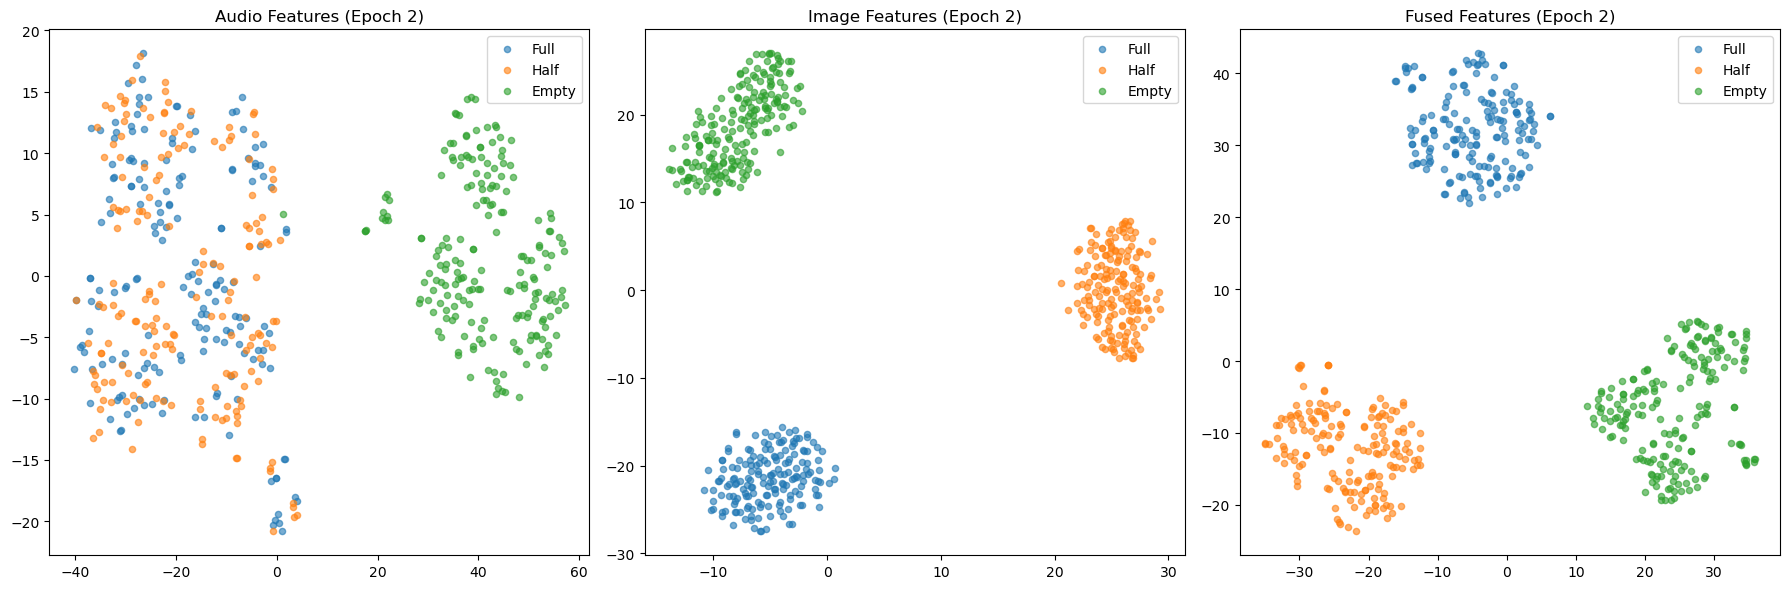

 13%|█▎        | 2/15 [09:15<59:49, 276.15s/it]  

Epoch [3/15] Train Loss: 0.0002, Train Acc: 1.0000, Val Loss: 0.0000, Val Acc: 1.0000


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x1463ea667f60>
Traceback (most recent call last):
  File "/sw/pkgs/arc/python3.11-anaconda/2024.02-1/lib/python3.11/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/sw/pkgs/arc/python3.11-anaconda/2024.02-1/lib/python3.11/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/sw/pkgs/arc/python3.11-anaconda/2024.02-1/lib/python3.11/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
                   ^^^^^^^^^^^^^^^^^^
  File "/sw/pkgs/arc/python3.11-anaconda/2024.02-1/lib/python3.11/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split

Label counts: Counter({2: 198, 1: 177, 0: 174})


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x1464239249a0>
Traceback (most recent call last):
  File "/sw/pkgs/arc/python3.11-anaconda/2024.02-1/lib/python3.11/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/sw/pkgs/arc/python3.11-anaconda/2024.02-1/lib/python3.11/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/sw/pkgs/arc/python3.11-anaconda/2024.02-1/lib/python3.11/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
                   ^^^^^^^^^^^^^^^^^^
  File "/sw/pkgs/arc/python3.11-anaconda/2024.02-1/lib/python3.11/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split

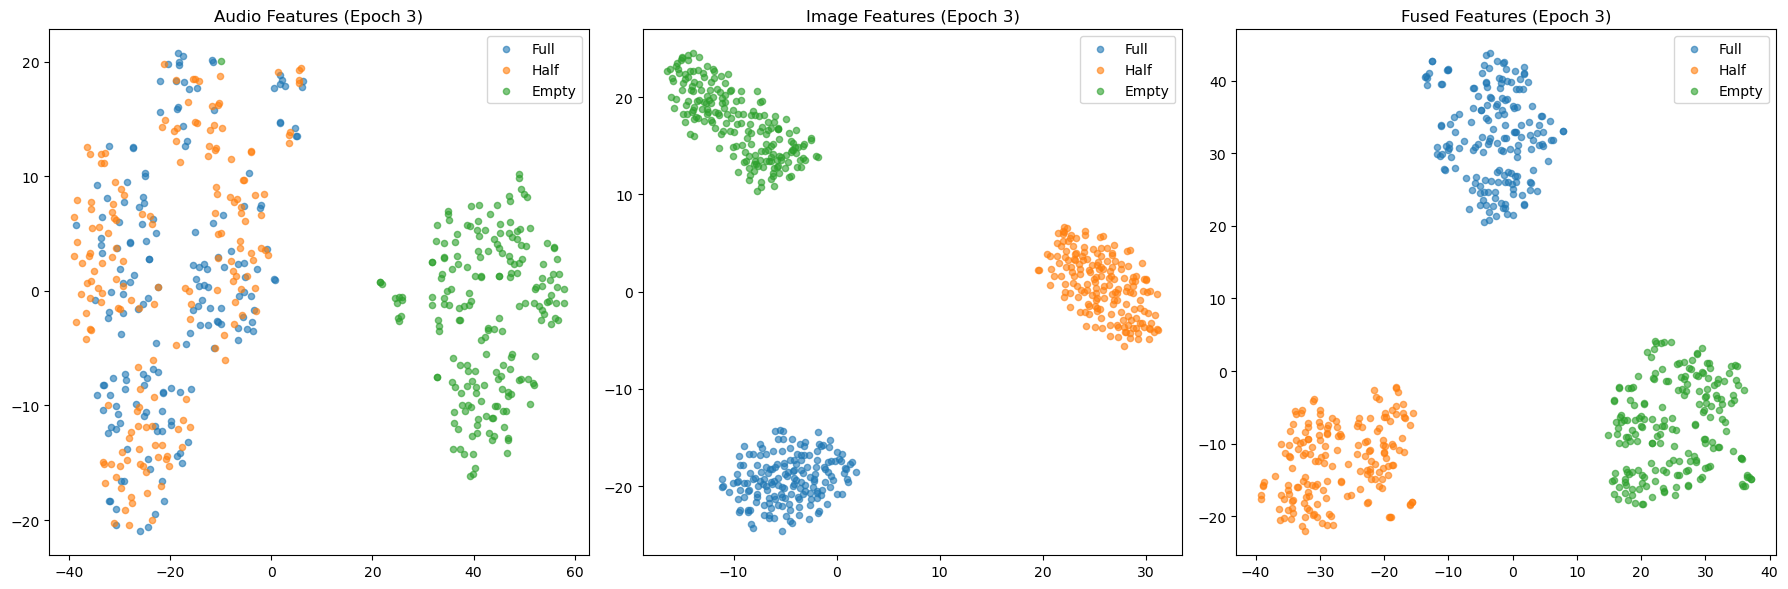

 20%|██        | 3/15 [13:52<55:18, 276.58s/it]

Epoch [4/15] Train Loss: 0.0001, Train Acc: 1.0000, Val Loss: 0.0000, Val Acc: 1.0000


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x1463e80ebe20>
Traceback (most recent call last):
  File "/sw/pkgs/arc/python3.11-anaconda/2024.02-1/lib/python3.11/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/sw/pkgs/arc/python3.11-anaconda/2024.02-1/lib/python3.11/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/sw/pkgs/arc/python3.11-anaconda/2024.02-1/lib/python3.11/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
                   ^^^^^^^^^^^^^^^^^^
  File "/sw/pkgs/arc/python3.11-anaconda/2024.02-1/lib/python3.11/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split

Label counts: Counter({2: 198, 1: 177, 0: 174})


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x1463e80ebd80>
Traceback (most recent call last):
  File "/sw/pkgs/arc/python3.11-anaconda/2024.02-1/lib/python3.11/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/sw/pkgs/arc/python3.11-anaconda/2024.02-1/lib/python3.11/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/sw/pkgs/arc/python3.11-anaconda/2024.02-1/lib/python3.11/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
                   ^^^^^^^^^^^^^^^^^^
  File "/sw/pkgs/arc/python3.11-anaconda/2024.02-1/lib/python3.11/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split

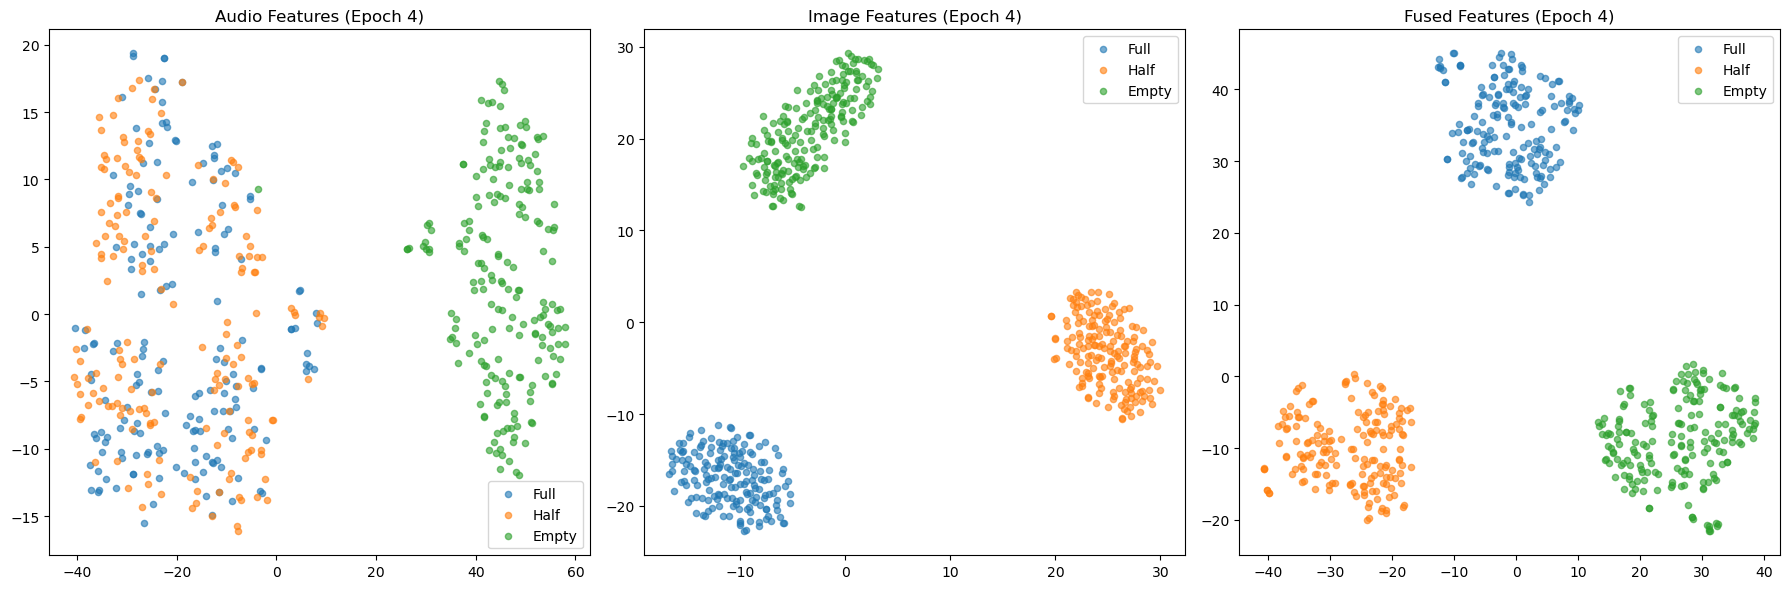

 27%|██▋       | 4/15 [18:20<50:05, 273.26s/it]

Epoch [5/15] Train Loss: 0.0001, Train Acc: 1.0000, Val Loss: 0.0000, Val Acc: 1.0000


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x1463e810a5c0>
Traceback (most recent call last):
  File "/sw/pkgs/arc/python3.11-anaconda/2024.02-1/lib/python3.11/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/sw/pkgs/arc/python3.11-anaconda/2024.02-1/lib/python3.11/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/sw/pkgs/arc/python3.11-anaconda/2024.02-1/lib/python3.11/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
                   ^^^^^^^^^^^^^^^^^^
  File "/sw/pkgs/arc/python3.11-anaconda/2024.02-1/lib/python3.11/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split

Label counts: Counter({2: 198, 1: 177, 0: 174})


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x1463e810a660>
Traceback (most recent call last):
  File "/sw/pkgs/arc/python3.11-anaconda/2024.02-1/lib/python3.11/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/sw/pkgs/arc/python3.11-anaconda/2024.02-1/lib/python3.11/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/sw/pkgs/arc/python3.11-anaconda/2024.02-1/lib/python3.11/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
                   ^^^^^^^^^^^^^^^^^^
  File "/sw/pkgs/arc/python3.11-anaconda/2024.02-1/lib/python3.11/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split

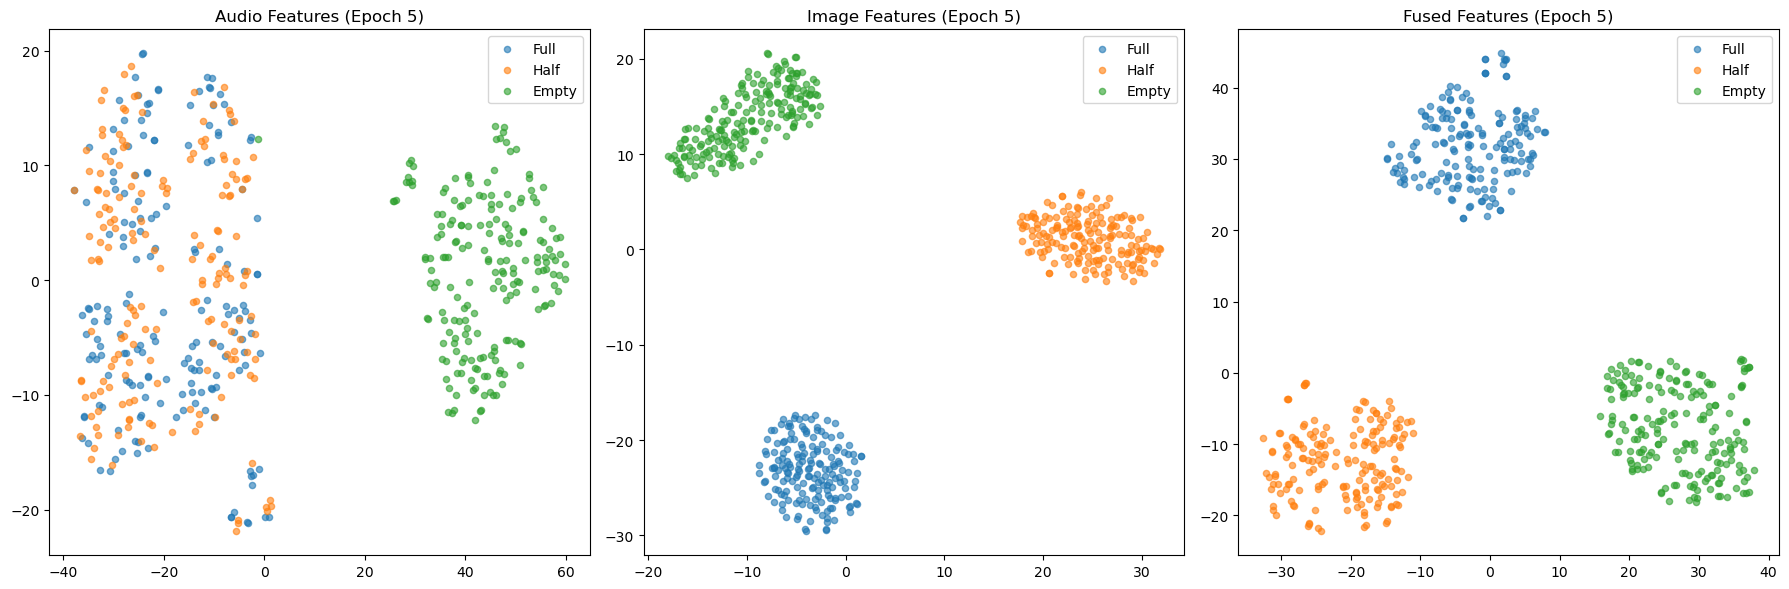

 33%|███▎      | 5/15 [22:26<43:52, 263.29s/it]

Epoch [6/15] Train Loss: 0.0002, Train Acc: 1.0000, Val Loss: 0.0000, Val Acc: 1.0000


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x14640829fba0>
Traceback (most recent call last):
  File "/sw/pkgs/arc/python3.11-anaconda/2024.02-1/lib/python3.11/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/sw/pkgs/arc/python3.11-anaconda/2024.02-1/lib/python3.11/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/sw/pkgs/arc/python3.11-anaconda/2024.02-1/lib/python3.11/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
                   ^^^^^^^^^^^^^^^^^^
  File "/sw/pkgs/arc/python3.11-anaconda/2024.02-1/lib/python3.11/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split

Label counts: Counter({2: 198, 1: 177, 0: 174})


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x14640829fba0>
Traceback (most recent call last):
  File "/sw/pkgs/arc/python3.11-anaconda/2024.02-1/lib/python3.11/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/sw/pkgs/arc/python3.11-anaconda/2024.02-1/lib/python3.11/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/sw/pkgs/arc/python3.11-anaconda/2024.02-1/lib/python3.11/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
                   ^^^^^^^^^^^^^^^^^^
  File "/sw/pkgs/arc/python3.11-anaconda/2024.02-1/lib/python3.11/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split

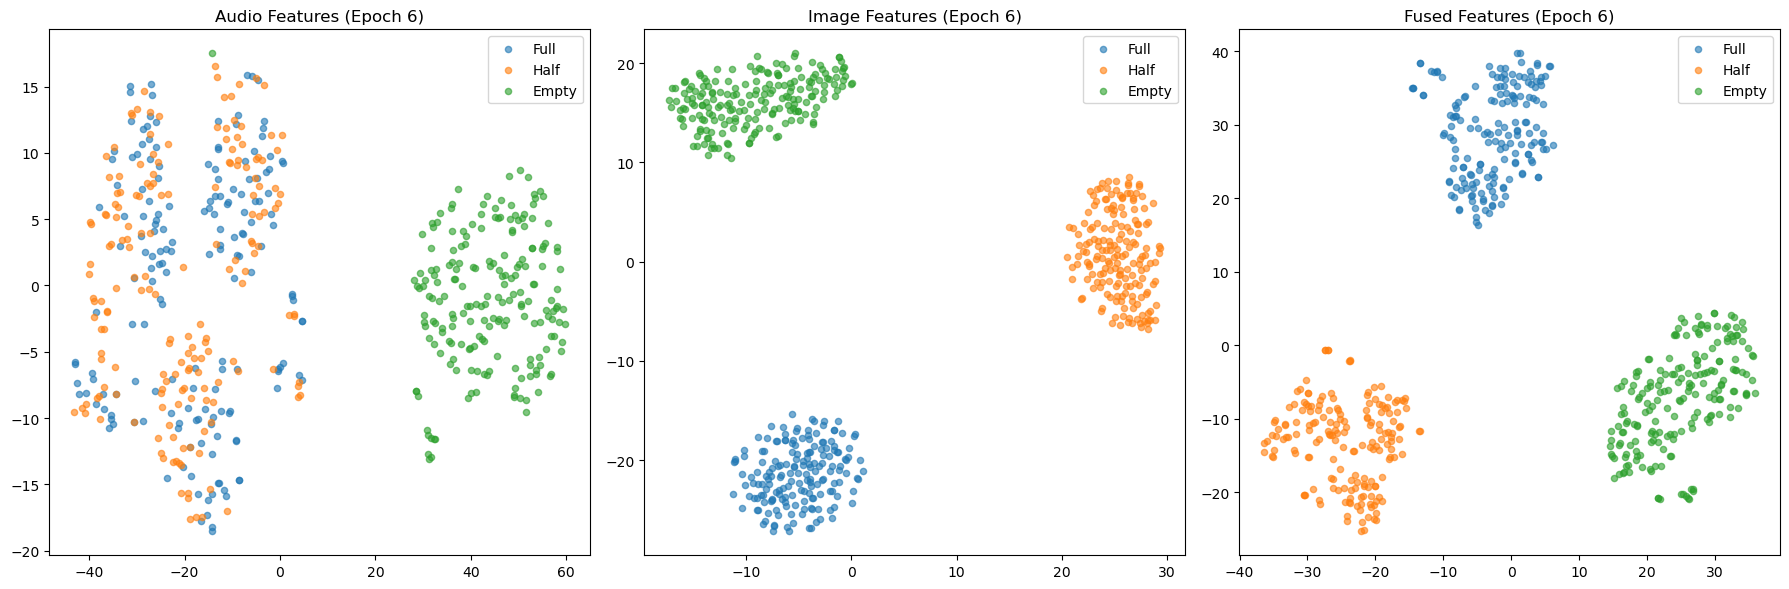

 40%|████      | 6/15 [26:29<38:28, 256.52s/it]

Epoch [7/15] Train Loss: 0.0014, Train Acc: 1.0000, Val Loss: 0.0001, Val Acc: 1.0000


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x1464083063e0>
Traceback (most recent call last):
  File "/sw/pkgs/arc/python3.11-anaconda/2024.02-1/lib/python3.11/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/sw/pkgs/arc/python3.11-anaconda/2024.02-1/lib/python3.11/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/sw/pkgs/arc/python3.11-anaconda/2024.02-1/lib/python3.11/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
                   ^^^^^^^^^^^^^^^^^^
  File "/sw/pkgs/arc/python3.11-anaconda/2024.02-1/lib/python3.11/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split

Label counts: Counter({2: 198, 1: 177, 0: 174})


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x146408306340>
Traceback (most recent call last):
  File "/sw/pkgs/arc/python3.11-anaconda/2024.02-1/lib/python3.11/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/sw/pkgs/arc/python3.11-anaconda/2024.02-1/lib/python3.11/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/sw/pkgs/arc/python3.11-anaconda/2024.02-1/lib/python3.11/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
                   ^^^^^^^^^^^^^^^^^^
  File "/sw/pkgs/arc/python3.11-anaconda/2024.02-1/lib/python3.11/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split

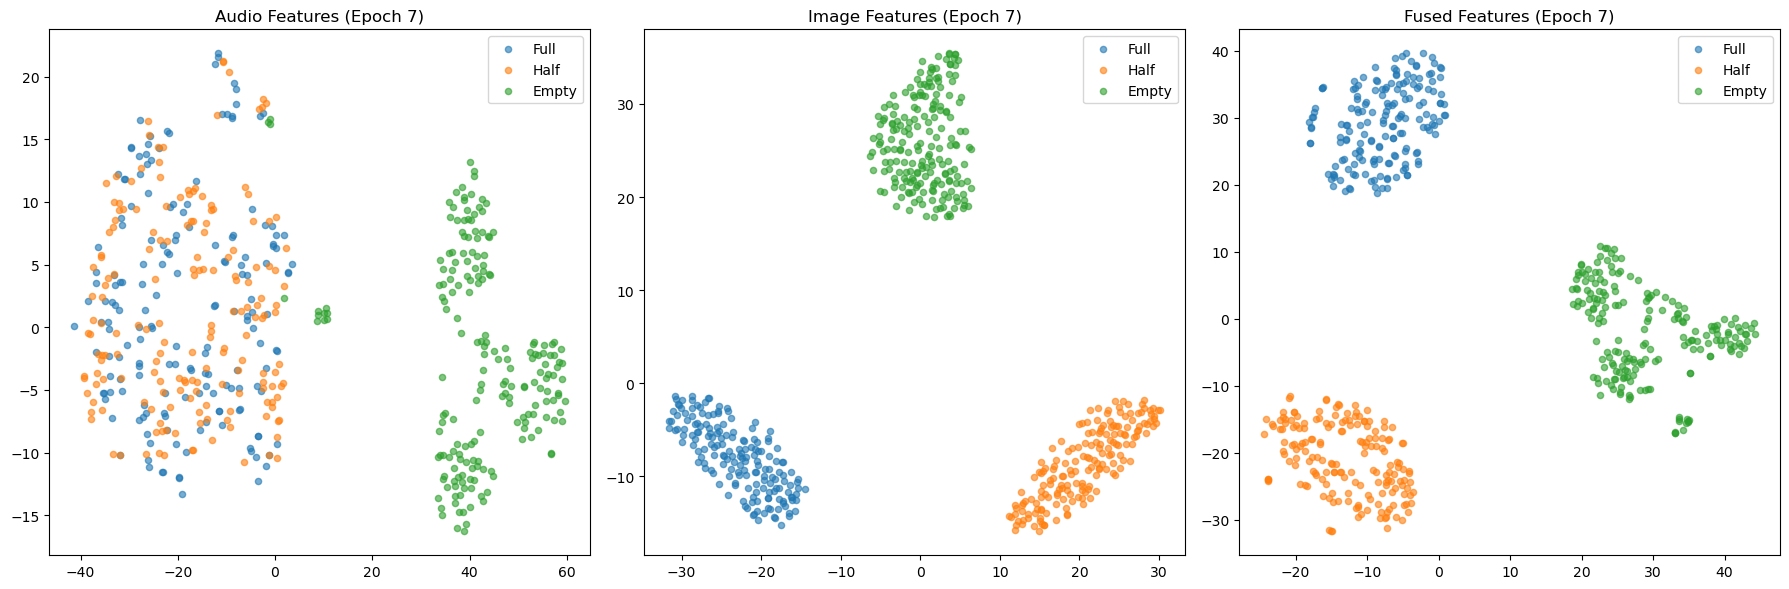

 47%|████▋     | 7/15 [30:29<33:29, 251.19s/it]

Epoch [8/15] Train Loss: 0.0002, Train Acc: 1.0000, Val Loss: 0.0000, Val Acc: 1.0000


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x1463e81e3240>
Traceback (most recent call last):
  File "/sw/pkgs/arc/python3.11-anaconda/2024.02-1/lib/python3.11/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/sw/pkgs/arc/python3.11-anaconda/2024.02-1/lib/python3.11/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/sw/pkgs/arc/python3.11-anaconda/2024.02-1/lib/python3.11/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
                   ^^^^^^^^^^^^^^^^^^
  File "/sw/pkgs/arc/python3.11-anaconda/2024.02-1/lib/python3.11/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split

Label counts: Counter({2: 198, 1: 177, 0: 174})


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x1463e81e3240>
Traceback (most recent call last):
  File "/sw/pkgs/arc/python3.11-anaconda/2024.02-1/lib/python3.11/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/sw/pkgs/arc/python3.11-anaconda/2024.02-1/lib/python3.11/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/sw/pkgs/arc/python3.11-anaconda/2024.02-1/lib/python3.11/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
                   ^^^^^^^^^^^^^^^^^^
  File "/sw/pkgs/arc/python3.11-anaconda/2024.02-1/lib/python3.11/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split

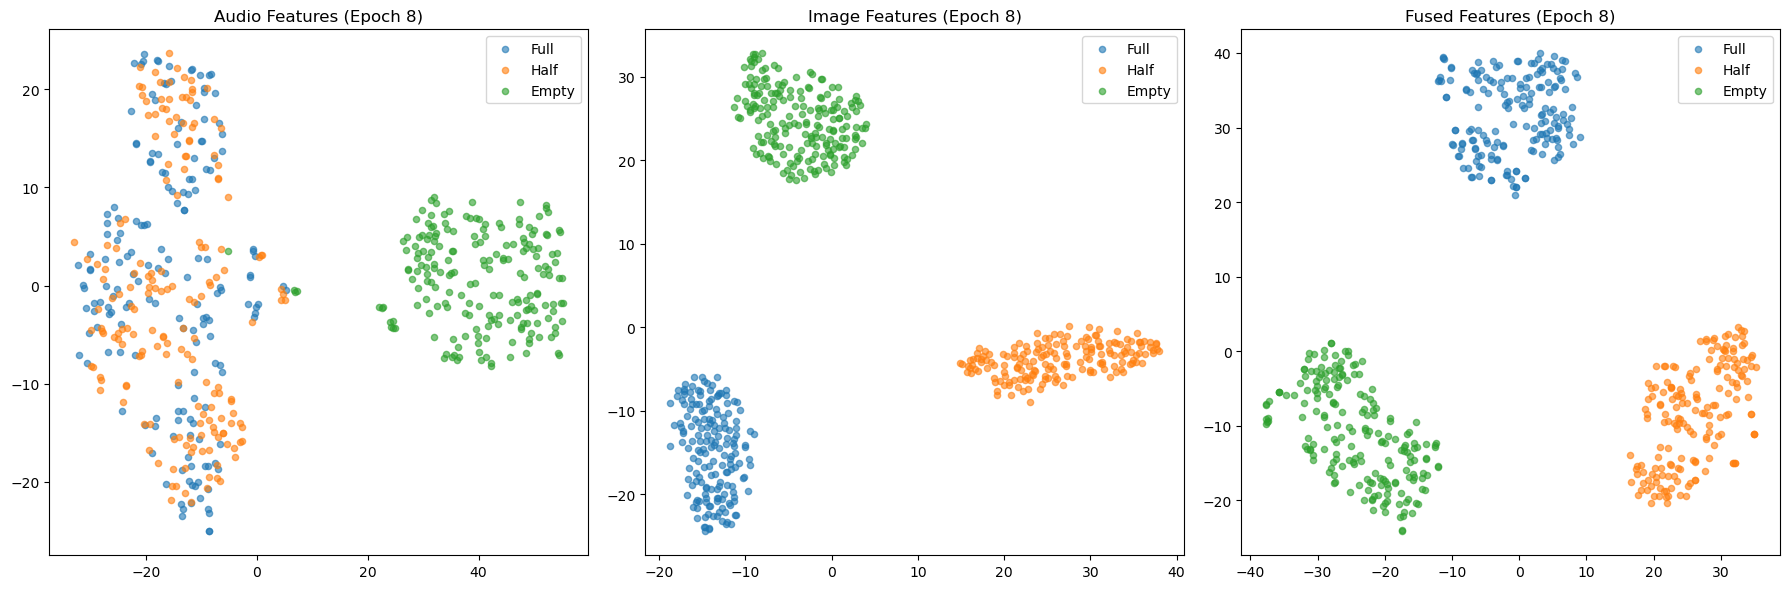

 53%|█████▎    | 8/15 [34:13<28:16, 242.35s/it]

Epoch [9/15] Train Loss: 0.0001, Train Acc: 1.0000, Val Loss: 0.0000, Val Acc: 1.0000


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x1463e8060180>
Traceback (most recent call last):
  File "/sw/pkgs/arc/python3.11-anaconda/2024.02-1/lib/python3.11/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/sw/pkgs/arc/python3.11-anaconda/2024.02-1/lib/python3.11/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/sw/pkgs/arc/python3.11-anaconda/2024.02-1/lib/python3.11/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
                   ^^^^^^^^^^^^^^^^^^
  File "/sw/pkgs/arc/python3.11-anaconda/2024.02-1/lib/python3.11/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split

Label counts: Counter({2: 198, 1: 177, 0: 174})


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x1463e80600e0>
Traceback (most recent call last):
  File "/sw/pkgs/arc/python3.11-anaconda/2024.02-1/lib/python3.11/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/sw/pkgs/arc/python3.11-anaconda/2024.02-1/lib/python3.11/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/sw/pkgs/arc/python3.11-anaconda/2024.02-1/lib/python3.11/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
                   ^^^^^^^^^^^^^^^^^^
  File "/sw/pkgs/arc/python3.11-anaconda/2024.02-1/lib/python3.11/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split

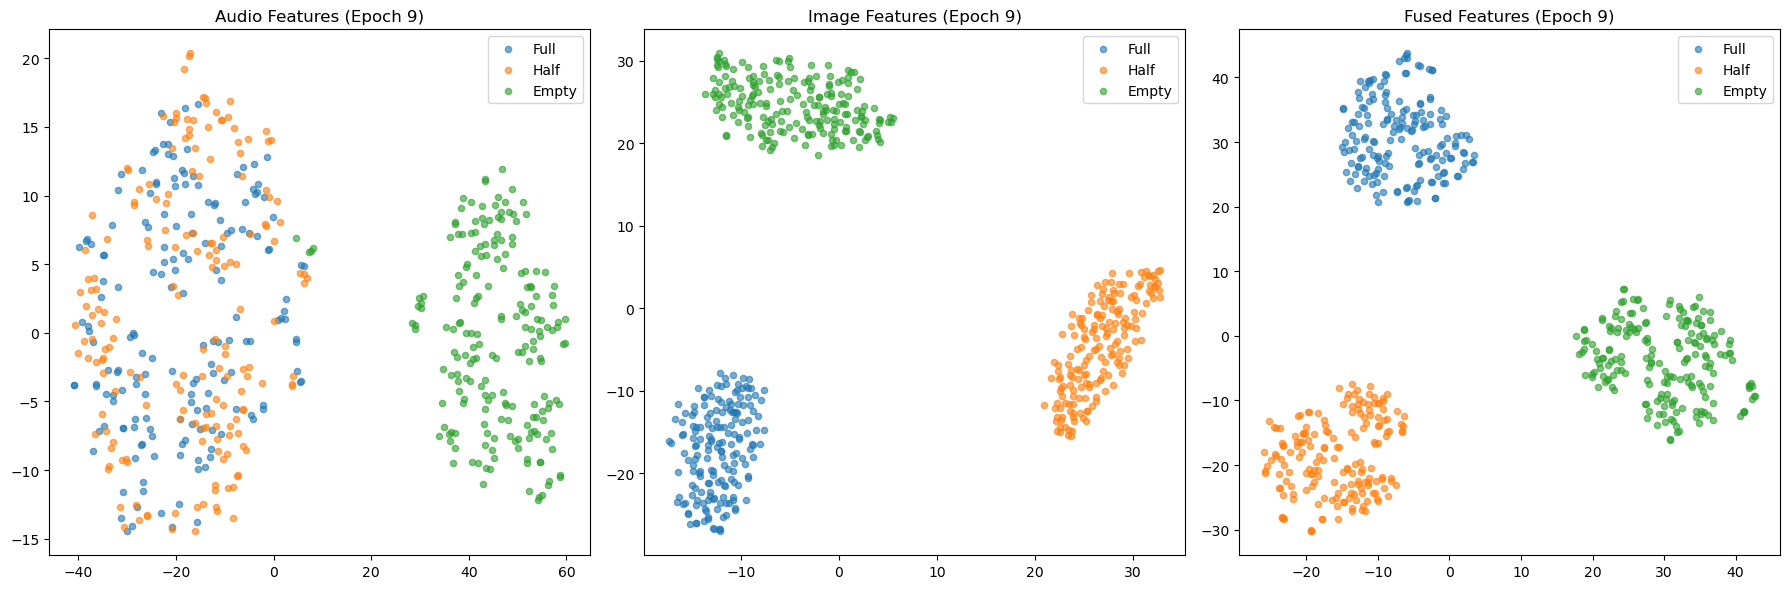

 60%|██████    | 9/15 [38:16<24:15, 242.56s/it]

Epoch [10/15] Train Loss: 0.0000, Train Acc: 1.0000, Val Loss: 0.0000, Val Acc: 1.0000


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x1463ea5ece00>
Traceback (most recent call last):
  File "/sw/pkgs/arc/python3.11-anaconda/2024.02-1/lib/python3.11/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/sw/pkgs/arc/python3.11-anaconda/2024.02-1/lib/python3.11/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/sw/pkgs/arc/python3.11-anaconda/2024.02-1/lib/python3.11/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
                   ^^^^^^^^^^^^^^^^^^
  File "/sw/pkgs/arc/python3.11-anaconda/2024.02-1/lib/python3.11/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split

Label counts: Counter({2: 198, 1: 177, 0: 174})


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x1463ea5ecd60>
Traceback (most recent call last):
  File "/sw/pkgs/arc/python3.11-anaconda/2024.02-1/lib/python3.11/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/sw/pkgs/arc/python3.11-anaconda/2024.02-1/lib/python3.11/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/sw/pkgs/arc/python3.11-anaconda/2024.02-1/lib/python3.11/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
                   ^^^^^^^^^^^^^^^^^^
  File "/sw/pkgs/arc/python3.11-anaconda/2024.02-1/lib/python3.11/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split

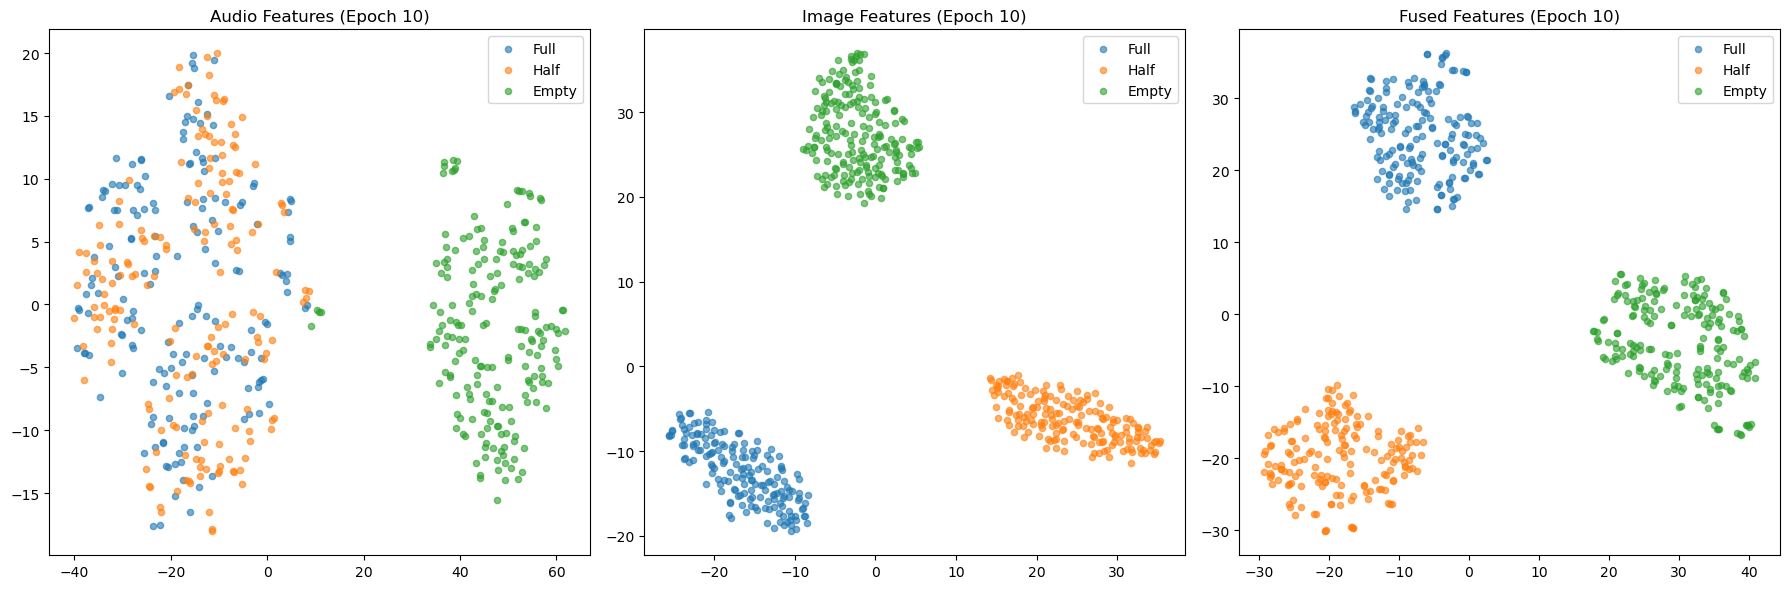

 67%|██████▋   | 10/15 [42:22<20:18, 243.74s/it]

Epoch [11/15] Train Loss: 0.0000, Train Acc: 1.0000, Val Loss: 0.0000, Val Acc: 1.0000


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x1463e829dc60>
Traceback (most recent call last):
  File "/sw/pkgs/arc/python3.11-anaconda/2024.02-1/lib/python3.11/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/sw/pkgs/arc/python3.11-anaconda/2024.02-1/lib/python3.11/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/sw/pkgs/arc/python3.11-anaconda/2024.02-1/lib/python3.11/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
                   ^^^^^^^^^^^^^^^^^^
  File "/sw/pkgs/arc/python3.11-anaconda/2024.02-1/lib/python3.11/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split

Label counts: Counter({2: 198, 1: 177, 0: 174})


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x1463e0acfb00>
Traceback (most recent call last):
  File "/sw/pkgs/arc/python3.11-anaconda/2024.02-1/lib/python3.11/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/sw/pkgs/arc/python3.11-anaconda/2024.02-1/lib/python3.11/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/sw/pkgs/arc/python3.11-anaconda/2024.02-1/lib/python3.11/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
                   ^^^^^^^^^^^^^^^^^^
  File "/sw/pkgs/arc/python3.11-anaconda/2024.02-1/lib/python3.11/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split

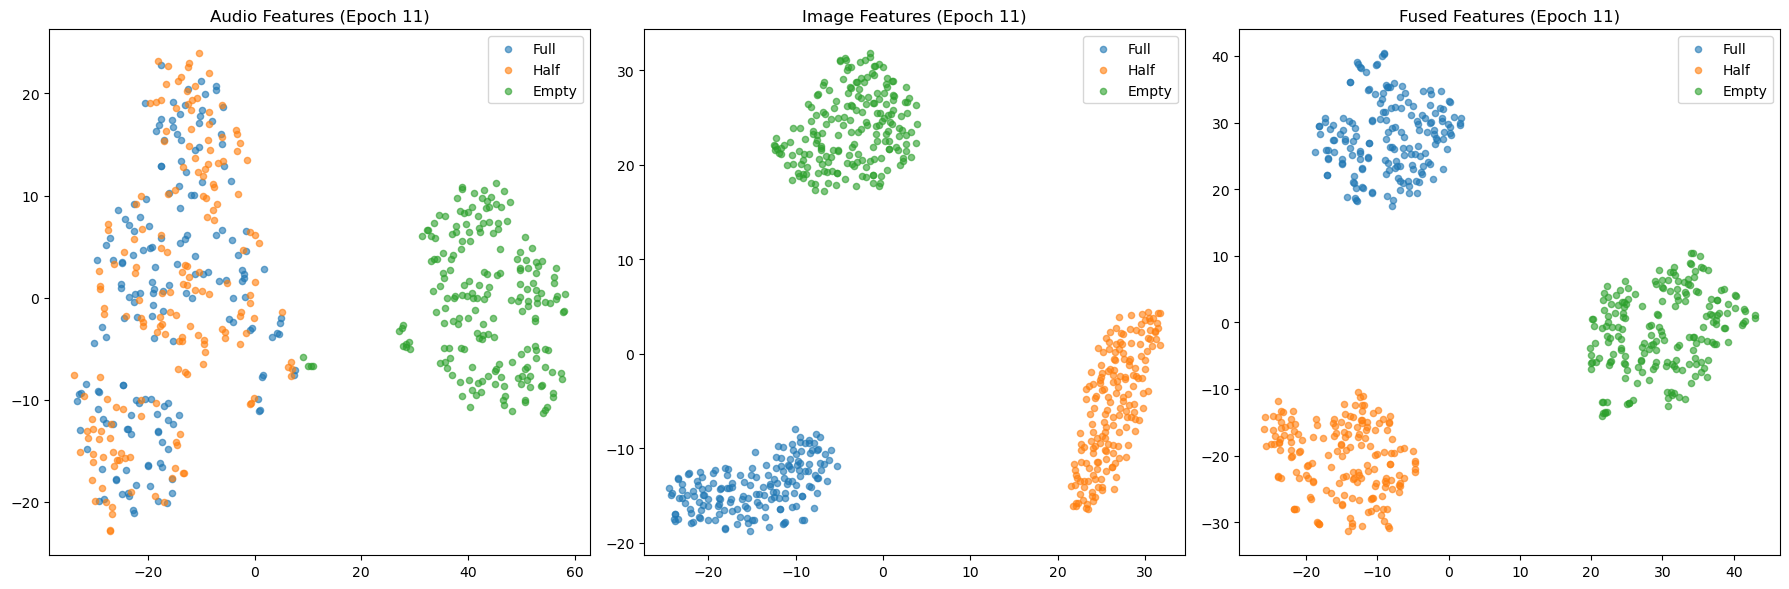

 73%|███████▎  | 11/15 [46:19<16:06, 241.67s/it]

Epoch [12/15] Train Loss: 0.0001, Train Acc: 1.0000, Val Loss: 0.0000, Val Acc: 1.0000


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x1463e0a7ab60>
Traceback (most recent call last):
  File "/sw/pkgs/arc/python3.11-anaconda/2024.02-1/lib/python3.11/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/sw/pkgs/arc/python3.11-anaconda/2024.02-1/lib/python3.11/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/sw/pkgs/arc/python3.11-anaconda/2024.02-1/lib/python3.11/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
                   ^^^^^^^^^^^^^^^^^^
  File "/sw/pkgs/arc/python3.11-anaconda/2024.02-1/lib/python3.11/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split

Label counts: Counter({2: 198, 1: 177, 0: 174})


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x1463e0a7aac0>
Traceback (most recent call last):
  File "/sw/pkgs/arc/python3.11-anaconda/2024.02-1/lib/python3.11/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/sw/pkgs/arc/python3.11-anaconda/2024.02-1/lib/python3.11/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/sw/pkgs/arc/python3.11-anaconda/2024.02-1/lib/python3.11/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
                   ^^^^^^^^^^^^^^^^^^
  File "/sw/pkgs/arc/python3.11-anaconda/2024.02-1/lib/python3.11/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split

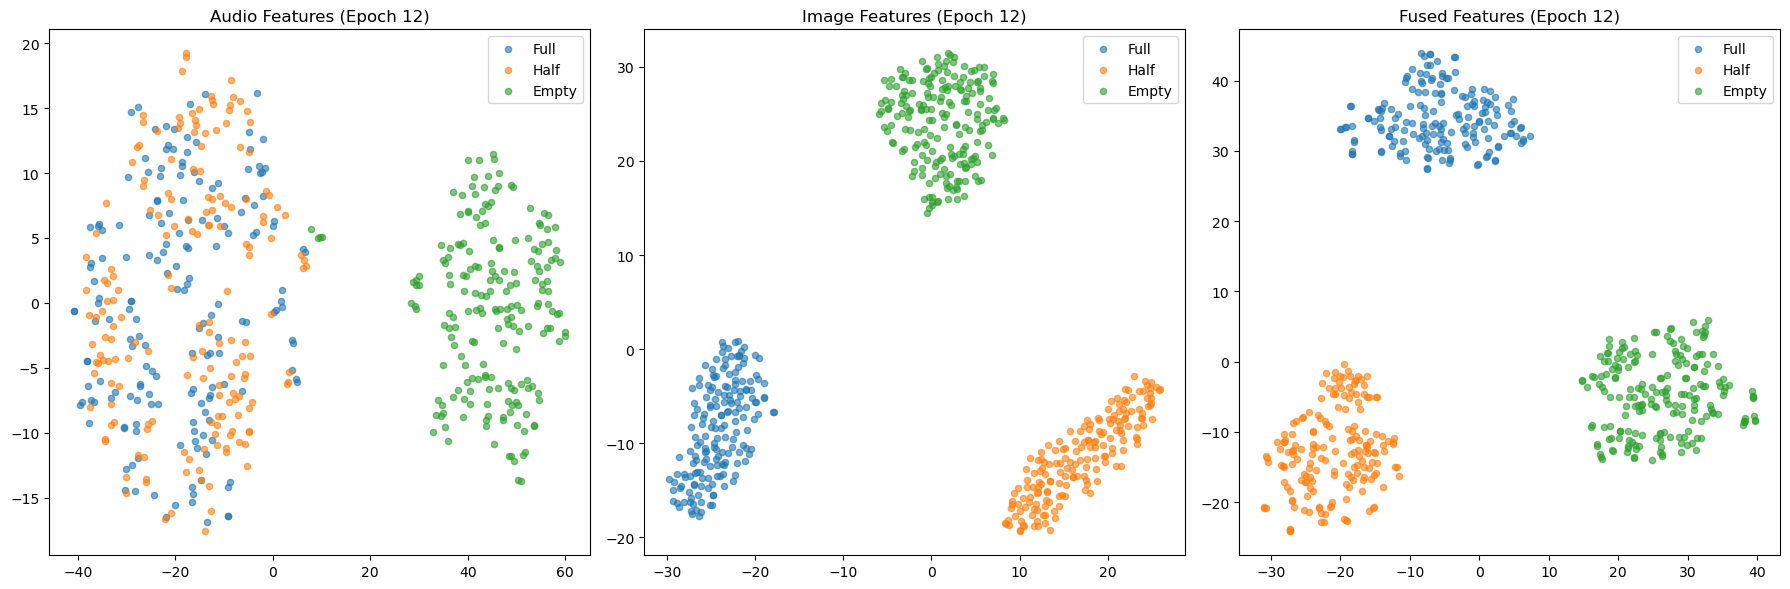

 80%|████████  | 12/15 [50:10<11:55, 238.42s/it]

Epoch [13/15] Train Loss: 0.0001, Train Acc: 1.0000, Val Loss: 0.0000, Val Acc: 1.0000


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x1463e05f3920>
Traceback (most recent call last):
  File "/sw/pkgs/arc/python3.11-anaconda/2024.02-1/lib/python3.11/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/sw/pkgs/arc/python3.11-anaconda/2024.02-1/lib/python3.11/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/sw/pkgs/arc/python3.11-anaconda/2024.02-1/lib/python3.11/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
                   ^^^^^^^^^^^^^^^^^^
  File "/sw/pkgs/arc/python3.11-anaconda/2024.02-1/lib/python3.11/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split

Label counts: Counter({2: 198, 1: 177, 0: 174})


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x1463e05f3920>
Traceback (most recent call last):
  File "/sw/pkgs/arc/python3.11-anaconda/2024.02-1/lib/python3.11/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/sw/pkgs/arc/python3.11-anaconda/2024.02-1/lib/python3.11/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/sw/pkgs/arc/python3.11-anaconda/2024.02-1/lib/python3.11/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
                   ^^^^^^^^^^^^^^^^^^
  File "/sw/pkgs/arc/python3.11-anaconda/2024.02-1/lib/python3.11/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split

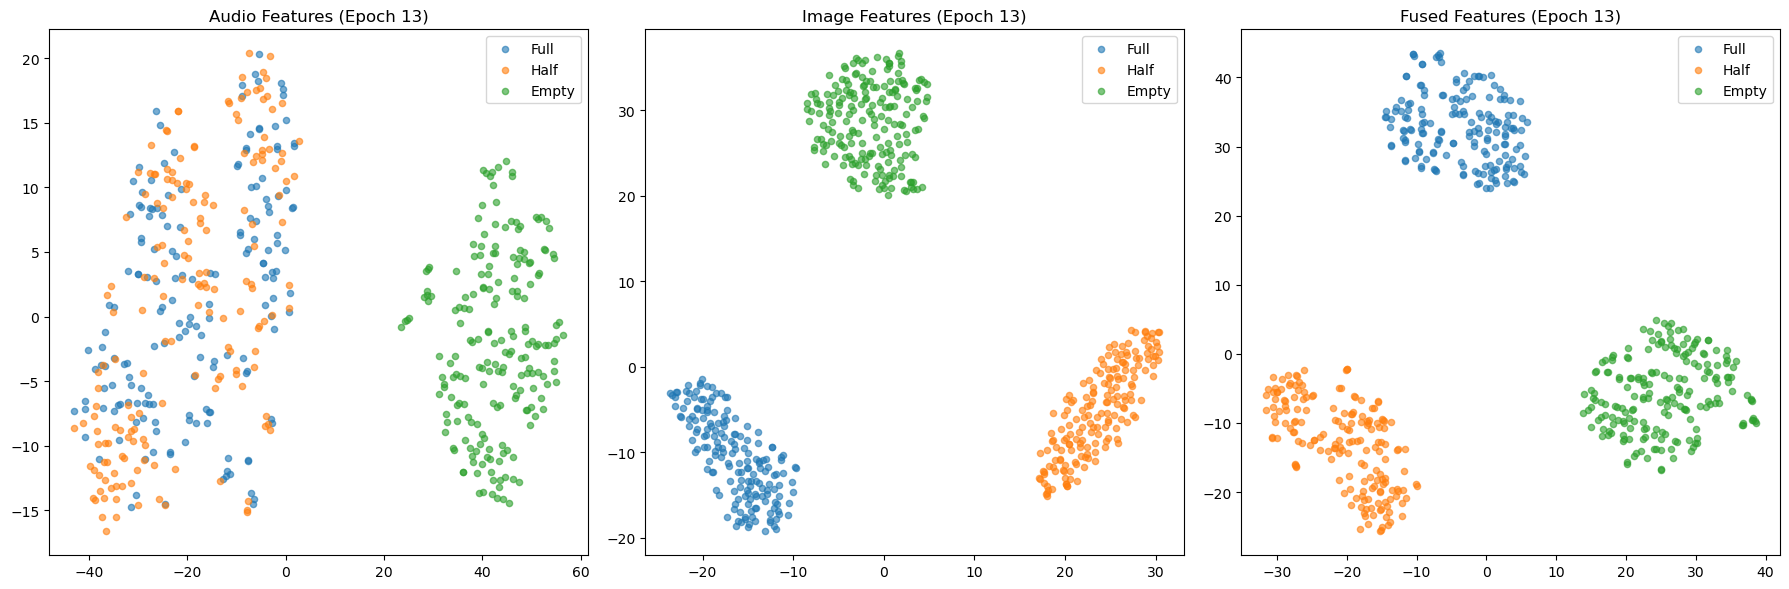

 87%|████████▋ | 13/15 [53:59<07:51, 235.59s/it]

Epoch [14/15] Train Loss: 0.0000, Train Acc: 1.0000, Val Loss: 0.0000, Val Acc: 1.0000


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x1463e808cea0>
Traceback (most recent call last):
  File "/sw/pkgs/arc/python3.11-anaconda/2024.02-1/lib/python3.11/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/sw/pkgs/arc/python3.11-anaconda/2024.02-1/lib/python3.11/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/sw/pkgs/arc/python3.11-anaconda/2024.02-1/lib/python3.11/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
                   ^^^^^^^^^^^^^^^^^^
  File "/sw/pkgs/arc/python3.11-anaconda/2024.02-1/lib/python3.11/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split

Label counts: Counter({2: 198, 1: 177, 0: 174})


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x1463e808cea0>
Traceback (most recent call last):
  File "/sw/pkgs/arc/python3.11-anaconda/2024.02-1/lib/python3.11/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/sw/pkgs/arc/python3.11-anaconda/2024.02-1/lib/python3.11/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/sw/pkgs/arc/python3.11-anaconda/2024.02-1/lib/python3.11/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
                   ^^^^^^^^^^^^^^^^^^
  File "/sw/pkgs/arc/python3.11-anaconda/2024.02-1/lib/python3.11/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split

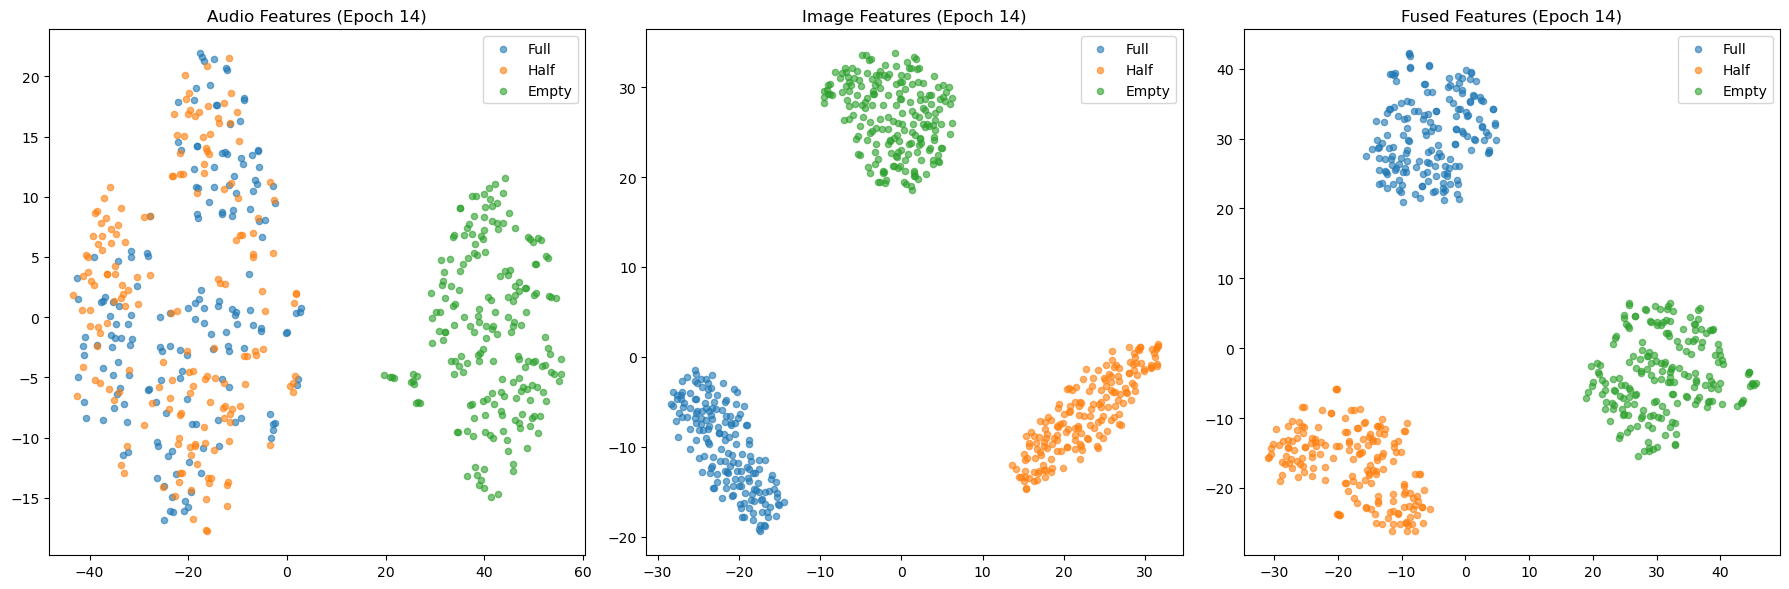

 93%|█████████▎| 14/15 [57:54<03:55, 235.34s/it]

Epoch [15/15] Train Loss: 0.0000, Train Acc: 1.0000, Val Loss: 0.0000, Val Acc: 1.0000


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x1464082af240>
Traceback (most recent call last):
  File "/sw/pkgs/arc/python3.11-anaconda/2024.02-1/lib/python3.11/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/sw/pkgs/arc/python3.11-anaconda/2024.02-1/lib/python3.11/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/sw/pkgs/arc/python3.11-anaconda/2024.02-1/lib/python3.11/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
                   ^^^^^^^^^^^^^^^^^^
  File "/sw/pkgs/arc/python3.11-anaconda/2024.02-1/lib/python3.11/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split

Label counts: Counter({2: 198, 1: 177, 0: 174})


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x1464082af060>
Traceback (most recent call last):
  File "/sw/pkgs/arc/python3.11-anaconda/2024.02-1/lib/python3.11/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/sw/pkgs/arc/python3.11-anaconda/2024.02-1/lib/python3.11/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/sw/pkgs/arc/python3.11-anaconda/2024.02-1/lib/python3.11/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
                   ^^^^^^^^^^^^^^^^^^
  File "/sw/pkgs/arc/python3.11-anaconda/2024.02-1/lib/python3.11/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split

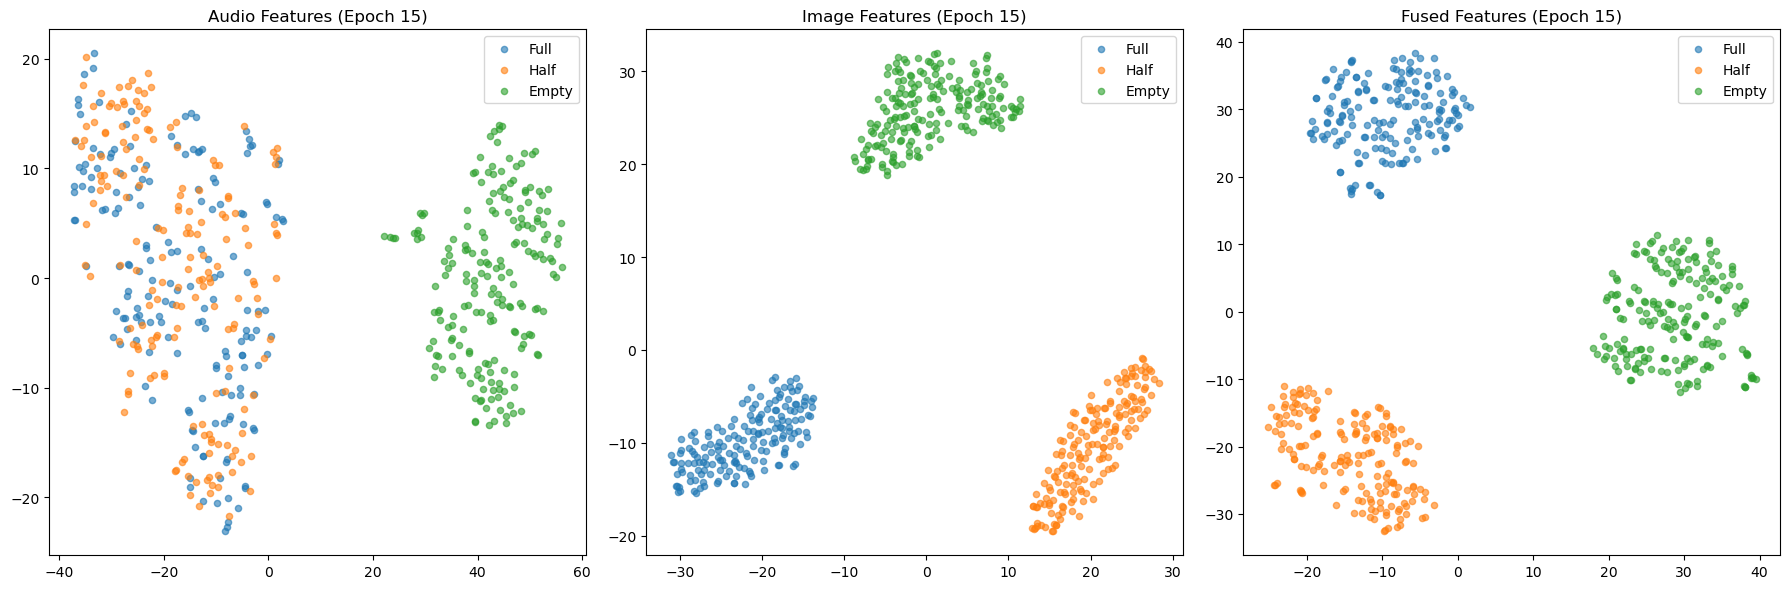

100%|██████████| 15/15 [1:01:48<00:00, 247.20s/it]


Visualizing features AFTER training...


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x1463e829dbc0>
Traceback (most recent call last):
  File "/sw/pkgs/arc/python3.11-anaconda/2024.02-1/lib/python3.11/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/sw/pkgs/arc/python3.11-anaconda/2024.02-1/lib/python3.11/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/sw/pkgs/arc/python3.11-anaconda/2024.02-1/lib/python3.11/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
                   ^^^^^^^^^^^^^^^^^^
  File "/sw/pkgs/arc/python3.11-anaconda/2024.02-1/lib/python3.11/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split

Label counts: Counter({2: 198, 1: 177, 0: 174})


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x1464082db740>
Traceback (most recent call last):
  File "/sw/pkgs/arc/python3.11-anaconda/2024.02-1/lib/python3.11/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/sw/pkgs/arc/python3.11-anaconda/2024.02-1/lib/python3.11/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/sw/pkgs/arc/python3.11-anaconda/2024.02-1/lib/python3.11/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
                   ^^^^^^^^^^^^^^^^^^
  File "/sw/pkgs/arc/python3.11-anaconda/2024.02-1/lib/python3.11/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split

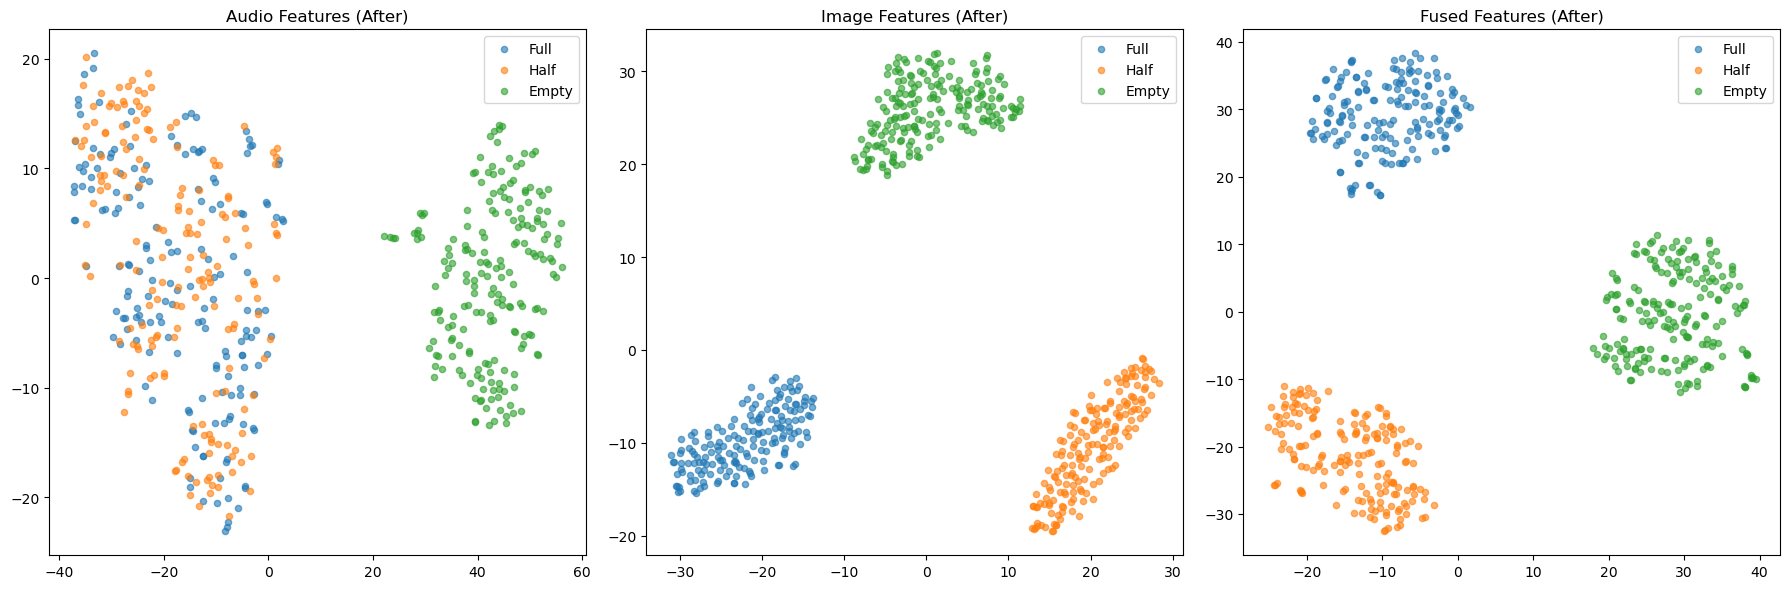

Training complete and model saved!


In [ ]:
import os, glob, subprocess, math
import numpy as np
from PIL import Image

from tqdm import tqdm

import torch, torch.nn as nn, torch.nn.functional as F, torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, models

import torchaudio
import torchaudio.transforms as T
import torchaudio.functional as AF

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from collections import Counter

# SETTINGS
RAW_VIDEOS   = "/scratch/zhanxiao_root/zhanxiao0/ppaiva/raw_videos"     # input videos
AUDIO_DIR    = "/scratch/zhanxiao_root/zhanxiao0/ppaiva/test01/audio_segments01"   # output 2s wavs
IMAGE_DIR    = "/scratch/zhanxiao_root/zhanxiao0/ppaiva/test01/recorded_images_03"  # output frame jpgs

SAMPLE_RATE  = 48000       
CHUNK_SECONDS= 2
N_MELS       = 64
BATCH_SIZE   = 20
EPOCHS       = 15
DEVICE       = "cuda" if torch.cuda.is_available() else "cpu"

label_map = {"full": 0, "half": 1, "empty": 2}
LABELS = {v: k.capitalize() for k, v in label_map.items()}

os.makedirs(AUDIO_DIR, exist_ok=True)
os.makedirs(IMAGE_DIR, exist_ok=True)

# EXTRACT 2s AUDIO + FRAMES FROM VIDEO
def extract_audio(video_path, wav_out, sample_rate=SAMPLE_RATE): #DEPRECATED!
    cmd = [
        "ffmpeg", "-y", "-i", video_path,
        "-ar", str(sample_rate), "-ac", "1", wav_out
    ]
    subprocess.run(cmd, stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL, check=True)

def extract_frame(video_path, image_out, timestamp): #DEPRECATED!
    cmd = ["ffmpeg", "-y", "-i", video_path, "-ss", f"{timestamp:.3f}", "-vframes", "1", image_out]
    subprocess.run(cmd, stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL, check=True)

def split_audio_and_frames(video_path, audio_dir=AUDIO_DIR, image_dir=IMAGE_DIR,
                           chunk_sec=CHUNK_SECONDS, sample_rate=SAMPLE_RATE): #DEPRECATED!
    base = os.path.splitext(os.path.basename(video_path))[0]   # e.g., full_8
    # 1) extract full audio
    full_audio = os.path.join(audio_dir, base + ".wav")
    extract_audio(video_path, full_audio, sample_rate=sample_rate)

    # 2) load and split into 2s chunks
    waveform, sr = torchaudio.load(full_audio)   # [1,T]
    if sr != sample_rate:
        waveform = torchaudio.functional.resample(waveform, sr, sample_rate)
        sr = sample_rate

    total_samples = waveform.shape[-1]
    chunk_samples = int(chunk_sec * sr)
    n_chunks = total_samples // chunk_samples

    for i in range(n_chunks):
        start = i * chunk_samples
        end   = start + chunk_samples
        seg   = waveform[:, start:end]                  
        seg_name = f"{base}_seg{i}.wav"
        seg_path = os.path.join(audio_dir, seg_name)
        torchaudio.save(seg_path, seg, sr)

        # frame at middle of window (i*2s + 1.0s)
        ts = (i * chunk_sec) + (chunk_sec / 2.0)
        frame_name = f"{base}_frame{i}.jpg"
        frame_path = os.path.join(image_dir, frame_name)
        extract_frame(video_path, frame_path, ts)

    print(f"[INFO] {base}: wrote {n_chunks} segments")

def fast_split(video_path, out_audio_dir, out_frame_dir):
    base = os.path.splitext(os.path.basename(video_path))[0]
    audio_pattern = os.path.join(out_audio_dir, f"{base}_seg%03d.wav")
    frame_pattern = os.path.join(out_frame_dir, f"{base}_frame%03d.jpg")

    subprocess.run([
        "ffmpeg", "-i", video_path,
        "-f", "segment", "-segment_time", "2",
        "-ar", "48000", "-ac", "1",
        "-c:a", "pcm_s16le",  # lossless 16-bit PCM
        audio_pattern
    ], check=True)

    subprocess.run([
        "ffmpeg", "-i", video_path,
        "-vf", "fps=0.5",  # 1 frame every 2 seconds
        "-qscale:v", "2",  # near-lossless JPEG quality
        frame_pattern
    ], check=True)

def prepare_dataset_from_videos(raw_videos=RAW_VIDEOS):
    video_files = []
    video_files.extend(glob.glob(os.path.join(raw_videos, "*.MOV")))
    video_files.extend(glob.glob(os.path.join(raw_videos, "*.mov")))
    video_files.extend(glob.glob(os.path.join(raw_videos, "*.mp4")))
    if not video_files:
        print(f"[WARN] No videos in {raw_videos}")
    for vf in video_files:
        print("[PROCESSING]", vf)        
        fast_split(vf, AUDIO_DIR, IMAGE_DIR)

# IMAGE TRANSFORM
gray = transforms.Grayscale(num_output_channels=3)
transform_image = transforms.Compose([
    transforms.Resize((224,224)),
    gray,
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])
])

# Audio cleaning for a 2s chunk (band-pass + quiet-frame spectral subtraction)
SR        = SAMPLE_RATE
BAND_LO   = 12000
BAND_HI   = 18000
NFFT      = 2048
HOP       = 512
OVERSUB   = 1.2
QUIET_PCT = 0.20

def _stft(x: torch.Tensor) -> torch.Tensor:
    if x.dim() == 2: x = x.squeeze(0)
    return torch.stft(x, n_fft=NFFT, hop_length=HOP, win_length=NFFT,
                      window=torch.hann_window(NFFT), return_complex=True, center=True)

def _istft(S: torch.Tensor, length: int) -> torch.Tensor:
    """
    Inverse STFT that accepts complex tensors when supported,
    and falls back to view_as_real format otherwise.
    Always uses a real-valued Hann window (float32).
    """
    win = torch.hann_window(NFFT, device=S.device, dtype=torch.float32)
    try:
        y = torch.istft(
            S, n_fft=NFFT, hop_length=HOP, win_length=NFFT,
            window=win, length=length, center=True
        )
    except (TypeError, RuntimeError):
        y = torch.istft(
            torch.view_as_real(S), n_fft=NFFT, hop_length=HOP, win_length=NFFT,
            window=win, length=length, center=True
        )
    return y

def bandpass_chunk(waveform: torch.Tensor, sr: int) -> torch.Tensor:
    """
    Band-pass in STFT domain by zeroing bins outside [BAND_LO, BAND_HI].
    Version-agnostic; avoids torchaudio biquad/lfilter kernels.
    Input:  waveform [1, T] (float32)
    Output: [1, T]
    """
    if waveform.dim() == 1:
        waveform = waveform.unsqueeze(0)
    x = waveform.squeeze(0).to(torch.float32)          # [T]

    # STFT
    S = torch.stft(x, n_fft=NFFT, hop_length=HOP, win_length=NFFT,
                   window=torch.hann_window(NFFT, dtype=torch.float32),
                   return_complex=True, center=True)   # [F, T], complex

    # Frequency mask
    freqs = np.fft.rfftfreq(NFFT, d=1.0/sr)
    lo = int(np.searchsorted(freqs, BAND_LO))
    hi = int(np.searchsorted(freqs, BAND_HI))
    lo = max(lo, 0); hi = min(hi, S.shape[0])

    mask = torch.zeros_like(S, dtype=torch.bool)       # [F, T]
    mask[lo:hi, :] = True
    S_bp = torch.where(mask, S, torch.zeros_like(S))

    # iSTFT back to time (compat wrapper)
    y = _istft(S_bp, length=x.numel())                 # [T]
    y = y - y.mean()
    y = torch.nan_to_num(y, nan=0.0, posinf=0.0, neginf=0.0)
    return y.unsqueeze(0)    

def spectral_subtract_quiet_frames(waveform: torch.Tensor, sr: int) -> torch.Tensor:
    x = waveform.squeeze(0)    # [T]
    Tlen = x.shape[-1]
    S = _stft(x)               # [F, T] complex
    Mag = S.abs()
    Pow = Mag**2

    freqs = np.fft.rfftfreq(NFFT, d=1.0/sr)
    lo = int(np.searchsorted(freqs, BAND_LO))
    hi = int(np.searchsorted(freqs, BAND_HI))
    lo = max(lo, 0); hi = min(hi, Mag.shape[0])

    band_pow_per_frame = Pow[lo:hi].mean(dim=0)         # [T_frames]
    T_frames = band_pow_per_frame.numel()
    k = max(1, int(round(QUIET_PCT * T_frames)))
    vals, idxs = torch.topk(-band_pow_per_frame, k)     # quietest frames
    quiet_mask = torch.zeros_like(band_pow_per_frame, dtype=torch.bool)
    quiet_mask[idxs] = True

    Npsd = Pow[:, quiet_mask].mean(dim=1, keepdim=True) # noise PSD
    Pclean = torch.clamp(Pow - OVERSUB * Npsd, min=0.0)
    Mag_clean = torch.sqrt(Pclean + 1e-12)
    S_clean = Mag_clean * torch.exp(1j * S.angle())
    y_clean = _istft(S_clean, length=Tlen)              # [T]
    y_clean = y_clean - y_clean.mean()
    y_clean = torch.nan_to_num(y_clean, nan=0.0, posinf=0.0, neginf=0.0)
    return y_clean.unsqueeze(0)

def clean_chunk(waveform: torch.Tensor, sr: int) -> torch.Tensor:
    if waveform.dim() == 2 and waveform.shape[0] > 1:
        waveform = waveform.mean(dim=0, keepdim=True)
    elif waveform.dim() == 1:
        waveform = waveform.unsqueeze(0)
    if sr != SR:
        waveform = torchaudio.functional.resample(waveform, sr, SR)
        sr = SR
    y_bp = bandpass_chunk(waveform, sr)
    y_cl = spectral_subtract_quiet_frames(y_bp, sr)
    return y_cl

# DATASET
class AudioImageDataset(Dataset):
    def __init__(self, audio_dir, image_dir, label_map, transform_image=None,
                 sample_rate=SAMPLE_RATE, n_mels=N_MELS, use_filters=True):
        self.audio_dir = audio_dir
        self.image_dir = image_dir
        self.label_map = label_map
        self.transform_image = transform_image
        self.sample_rate = sample_rate
        self.n_mels = n_mels
        self.use_filters = use_filters

        self.audio_files, self.labels, self.video_ids = [], [], []
        for file in os.listdir(audio_dir):
            if file.endswith(".wav") and "_seg" in file:
                frame_file = file.replace("seg", "frame").replace(".wav", ".jpg")
                if not os.path.exists(os.path.join(image_dir, frame_file)):
                    continue
                base_name = file.split("_seg")[0]                
                label_str = base_name.split("_")[0].lower()
                if label_str in label_map:
                    self.audio_files.append(file)                 
                    self.labels.append(label_map[label_str])
                    self.video_ids.append(file)                   

        # Audio -> Mel
        self.mel = T.MelSpectrogram(sample_rate=self.sample_rate, n_fft=1024,
                                    hop_length=512, n_mels=self.n_mels)
        self.db  = T.AmplitudeToDB()

    def __len__(self):
        return len(self.audio_files)

    def __getitem__(self, idx):
        audio_file = self.audio_files[idx]         
        label      = self.labels[idx]
        seg_id     = self.video_ids[idx]

        # ---- AUDIO ----
        a_path = os.path.join(self.audio_dir, audio_file)
        waveform, sr = torchaudio.load(a_path)     # 2s chunk
        if self.use_filters:
            waveform = clean_chunk(waveform, sr)   # [1, T] @ 48k
        else:
            if sr != self.sample_rate:
                waveform = torchaudio.functional.resample(waveform, sr, self.sample_rate)

        spec = self.mel(waveform)                  # [1, n_mels, time]
        spec = self.db(spec)
        spec = (spec - spec.mean()) / (spec.std() + 1e-6)
        spec = F.interpolate(spec.unsqueeze(0), size=(224,224), mode="bilinear", align_corners=False)
        spec = spec.mean(dim=1)                    # [1,224,224]

        # ---- IMAGE ----
        frame_file = audio_file.replace("seg", "frame").replace(".wav", ".jpg")
        img_path = os.path.join(self.image_dir, frame_file)
        img = Image.open(img_path).convert("RGB")
        if self.transform_image:
            img = self.transform_image(img)

        return spec, img, label, seg_id            

# DATA LOADERS
def create_loaders(dataset, batch_size=BATCH_SIZE):
    train_size = int(0.8 * len(dataset))
    val_size   = len(dataset) - train_size
    train_ds, val_ds = random_split(dataset, [train_size, val_size])
    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
    val_loader   = DataLoader(val_ds, batch_size=batch_size, shuffle=False)
    print(f"Train samples: {len(train_ds)}, Val samples: {len(val_ds)}")
    return train_loader, val_loader

# MODEL
class MultiModalResNet(nn.Module):
    def __init__(self, num_classes=3):
        super().__init__()
        self.audio_model = models.resnet18(pretrained=True)
        self.audio_model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.audio_model.fc = nn.Identity()
        self.image_model = models.resnet18(pretrained=True)
        self.image_model.fc = nn.Identity()
        self.fc = nn.Linear(512*2, num_classes)

    def forward(self, audio, image, return_features=False):
        a = self.audio_model(audio)
        i = self.image_model(image)
        fused = torch.cat([a, i], dim=1)       
        out = self.fc(fused)
        if return_features:
            return a, i, fused, out
        return out

# FEATURE VISUALIZATION (t-SNE)
def visualize_features(model, dataloader, title_suffix=""):
    model.eval()
    audio_feats, image_feats, fused_feats, labels_all = [], [], [], []
    with torch.no_grad():
        for audio, img, labels, _ in dataloader:
            audio, img, labels = audio.to(DEVICE), img.to(DEVICE), labels.to(DEVICE)
            a, i, fused, _ = model(audio, img, return_features=True)
            audio_feats.append(a.cpu()); image_feats.append(i.cpu()); fused_feats.append(fused.cpu())
            labels_all.append(labels.cpu())
    audio_feats = torch.cat(audio_feats).numpy()
    image_feats = torch.cat(image_feats).numpy()
    fused_feats = torch.cat(fused_feats).numpy()
    labels_all = torch.cat(labels_all).numpy()

    print("Label counts:", Counter(labels_all))
    n = fused_feats.shape[0]
    perpl = min(30, max(2, n//3))
    tsne = TSNE(n_components=2, random_state=42, perplexity=perpl)
    A2 = tsne.fit_transform(audio_feats)
    I2 = tsne.fit_transform(image_feats)
    F2 = tsne.fit_transform(fused_feats)

    fig, axes = plt.subplots(1,3, figsize=(18,6))
    for data2d, name, ax in zip([A2, I2, F2], ["Audio", "Image", "Fused"], axes):
        for l in sorted(set(labels_all)):
            idx = labels_all == l
            ax.scatter(data2d[idx,0], data2d[idx,1], alpha=0.6, s=20, label=LABELS[l])
        ax.set_title(f"{name} Features {title_suffix}"); ax.legend()
    plt.tight_layout(); plt.show()

# TRAINING
def train():
    # prepare_dataset_from_videos(RAW_VIDEOS)

    dataset = AudioImageDataset(audio_dir=AUDIO_DIR, image_dir=IMAGE_DIR,
                                label_map=label_map, transform_image=transform_image,
                                sample_rate=SAMPLE_RATE, n_mels=N_MELS, use_filters=True)
    if len(dataset) == 0:
        print("[ERROR] No segments found. Did you run prepare_dataset_from_videos()?"); return

    train_loader, val_loader = create_loaders(dataset, batch_size=BATCH_SIZE)

    model = MultiModalResNet(num_classes=len(label_map)).to(DEVICE)
    optimizer = optim.Adam(model.parameters(), lr=1e-4)
    criterion = nn.CrossEntropyLoss()

    print("Visualizing features BEFORE training...")
    visualize_features(model, val_loader, title_suffix="(Before)")

    for epoch in tqdm(range(EPOCHS)):
        # TRAIN
        model.train()
        running_loss, correct, total = 0.0, 0, 0
        for audio, img, labels, seg_ids in train_loader:
            audio, img, labels = audio.to(DEVICE), img.to(DEVICE), labels.to(DEVICE)
            optimizer.zero_grad()
            outputs = model(audio, img)
            loss = criterion(outputs, labels)
            loss.backward(); optimizer.step()

            running_loss += loss.item() * audio.size(0)
            _, preds = outputs.max(1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        train_loss = running_loss / max(1,total)
        train_acc  = correct / max(1,total)

        # VALIDATION
        model.eval()
        val_loss, val_correct, val_total = 0.0, 0, 0
        val_preds, val_labels, val_segids = [], [], []
        with torch.no_grad():
            for audio, img, labels, seg_ids in val_loader:
                audio, img, labels = audio.to(DEVICE), img.to(DEVICE), labels.to(DEVICE)
                outputs = model(audio, img)
                loss = criterion(outputs, labels)

                val_loss += loss.item() * audio.size(0)
                _, preds = outputs.max(1)
                val_correct += (preds == labels).sum().item()
                val_total   += labels.size(0)

                val_preds.extend(preds.cpu().tolist())
                val_labels.extend(labels.cpu().tolist())
                val_segids.extend(seg_ids)

        val_loss /= max(1,val_total)
        val_acc   = val_correct / max(1,val_total)

        print(f"Epoch [{epoch+1}/{EPOCHS}] "
              f"Train Loss: {round(train_loss,4):.4f}, Train Acc: {train_acc:.4f}, "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

        # (Optional) visualize every few epochs
        # if (epoch+1) % 5 == 0:
        visualize_features(model, val_loader, title_suffix=f"(Epoch {epoch+1})")

    print("Visualizing features AFTER training...")
    visualize_features(model, val_loader, title_suffix="(After)")

    torch.save(model.state_dict(), "multimodal_model_battery_v3.pth")
    print("Training complete and model saved!")

# MAIN
if __name__ == "__main__":
    # prepare_dataset_from_videos(RAW_VIDEOS)
    train()